# DARTS: Differentiable Architecture Search (Hanxiao Liu, Karen Simonyan, Yiming Yang)

This example demonstrates implementation of DARTS method [paper](https://arxiv.org/abs/1806.09055).

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from craynn import *
from craynn.viz import draw_to_notebook, SimpleWatcher

## MNIST data

In [2]:
data_train, labels_train, data_test, labels_test = utils.mnist(root='./data', one_hot=True, cast='float32')

In [3]:
### train/val split
train_size = int(0.9 * data_train.shape[0])
indx = np.random.permutation(data_train.shape[0])

data_train, data_val = data_train[indx[:train_size]], data_train[indx[train_size:]]
labels_train, labels_val = labels_train[indx[:train_size]], labels_train[indx[train_size:]]

In [4]:
### get_gpu/cpu_session is a handy helper to avoid writing full config.
### see the source code for the details.
session = get_gpu_session(memory_fraction=0.5)

In [5]:
### in order to improve performance, we load data set as tensorflow variables
### for some reason variables results in slightly better performance than constants
### and also can be changed.
### However, tensorflow is quite memory hungry, thus, for a larger datasets it is recommended to use `tf.data` utilities

### `variable_dataset` creates an helper object that helds dataset variables.
X_train, y_train, X_val, y_val = variable_dataset(session, data_train, labels_train, data_val, labels_val).batch(32)

## Network definition

`craynn.networks.meta.net` allows a quick and flexible definition.
It uses `craynn.subnetworks.meta.achain` method to generate the network, see documentation on `achain` for further details.

In [6]:
### `block` defines possible choices for convolutional block, all result in the output of the same shape as
### required for DARTS.
block = lambda n : [
    (conv(2 * n), conv(3 * n), max_pool()),
    (pconv(2 * n, stride=2), conv(3 * n)),
]

### `softmax_gate` mixes incoming values according to softmax of its weights `w`.
### The default property of `w` is weights=True (meaning it is subject to regularization).
### In order to exclude `gate` parameters from training we declare its to be hyper_parameter=True, and clear
### `weights` property.
### Note that properties have no fixed meaning,
#### nothing stops one from regularizing `biases` and train `hyper_parameters`.
gate = lambda : softmax_gate(w=zeros_init(weights=False, hyper_parameter=True))

nn = net((None, 28, 28, 1))(
    block(16), gate(),
    block(32), gate(),
    conv(64, kernel_size=(4, 4)), flatten(),
    softmax(10)
)

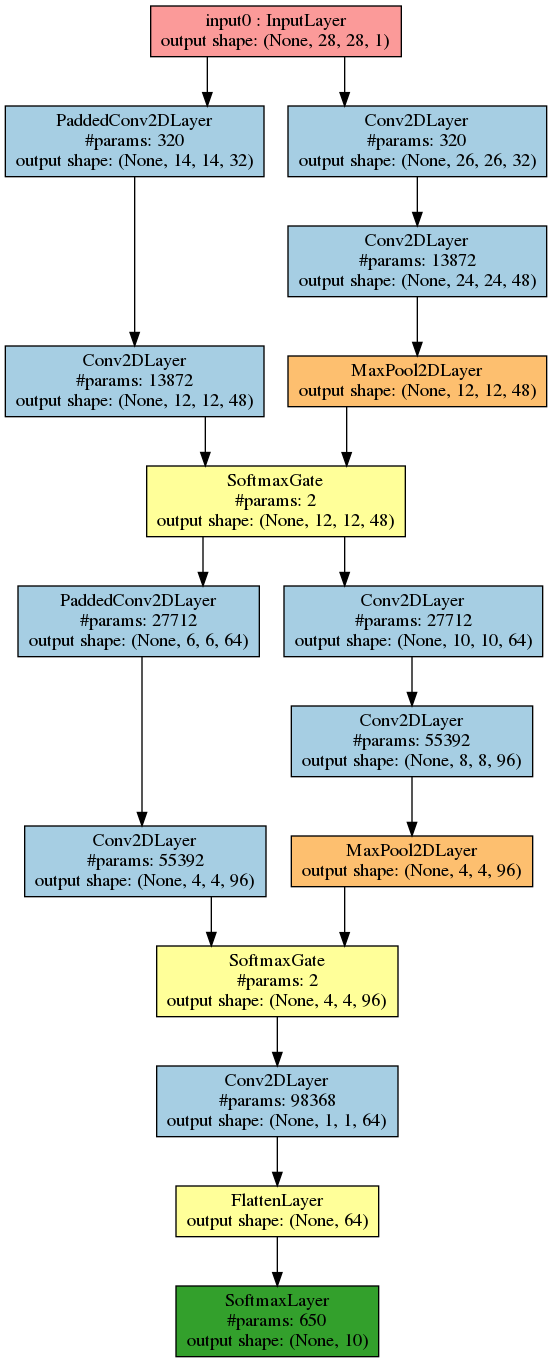

In [7]:
draw_to_notebook(nn)

In [8]:
### a network is just a function.

### note, network always returns a tuple of tensors even if there is only one.
### No particular reason, just a tradition.
predictions_train, = nn(X_train)
predictions_val, = nn(X_val)

In [9]:
### Note `gate`s parameters are excluded be `weights=True` (which is the default for regularization methods).
regularization = nn.reg_l2(weights=True)

loss_train = -tf.reduce_mean(tf.reduce_sum(y_train * tf.log(predictions_train), axis=1)) + 1.0e-3 * regularization

### Maybe it is better to also include regularization here.
loss_val = -tf.reduce_mean(tf.reduce_sum(y_val * tf.log(predictions_val), axis=1))

In [10]:
### all parameters with either absent or False value of the `hyper_parameter` property are selected.
variables_train = nn.variables(hyper_parameter=False)

### all parameters with `hyper_parameter=True` are selected.
### if a property is not defined for a parameter it is cosidered to be False.
variables_val = nn.variables(hyper_parameter=True)

Here a simple hack is used to anticapite training loss:
$$ \mathcal{L}_\mathrm{anticipated}(\theta, \psi) = \mathcal{L}_\mathrm{val}(\theta + \xi \nabla_\theta \mathcal{L}_\mathrm{train}(\theta, \psi), \psi)$$
where:
- $\theta$ - model parameters;
- $\psi$ - hyper-parameters (gates' mixing coefficients).

Instead of recomputing outputs of the networks with modified parameters:
1. gradient $\nabla_\theta \mathcal{L}_{\mathrm{train}}$ is stored;
2. stored gradient is applied to the parameters $\theta := \theta - \xi \nabla_\theta \mathcal{L}_\mathrm{train}$;
3. one descent step by $\nabla_\psi \mathcal{L}_\mathrm{val}(\theta)$ is performed;
4. original parameters are recovered: $\theta := \theta + \xi \nabla_\theta \mathcal{L}_\mathrm{train}$

In [11]:
### anticapation rate (see the paper for the details)
eps = tf.constant(1.0e-3, dtype='float32')

### a simple hack is used to compute L_val(params + eps * grad L_train(params))
grad_train = tf.gradients(loss_train, variables_train)

anticipation_grad = utils.variables_like(variables_train)

store_anticipation_grad = utils.assign(anticipation_grad, grad_train)
anticipate = utils.assign_sub(variables_train, [ eps * g for g in anticipation_grad ])
restore = utils.assign_add(variables_train, [ eps * g for g in anticipation_grad ])

In [12]:
optimizer_train = tf_updates.adam()(loss_train, variables_train)
optimizer_val = tf_updates.adam()(loss_val, variables_val)

In [13]:
updates_train = optimizer_train.updates()
updates_val = optimizer_val.updates()

### Initialization

Most of the `craynn` objects have a `reset` method that initializes all variables used by the object.

In [14]:
_ = session.run([nn.reset(), utils.reset(anticipation_grad), optimizer_train.reset(), optimizer_val.reset()])

### Training

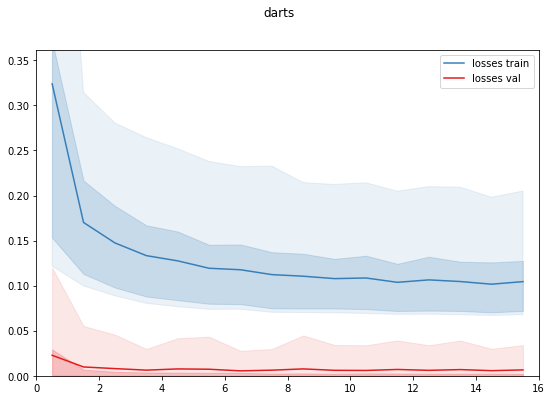

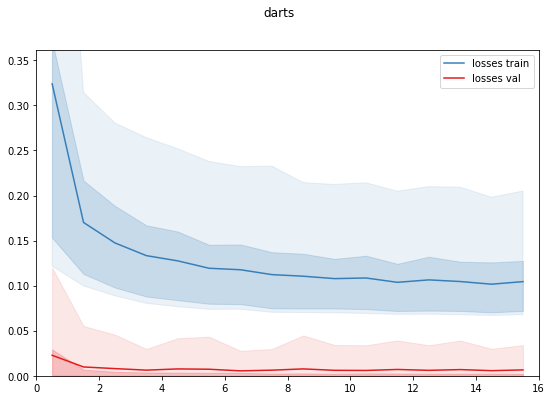

In [15]:
n_epoches = 16
n_batches = data_train.shape[0] // 32

losses_train = np.zeros((n_epoches, n_batches), dtype='float32')
losses_val = np.zeros((n_epoches, n_batches), dtype='float32')

watcher = SimpleWatcher(title='darts', labels=('losses train', 'losses val'))

for i in range(n_epoches):
    for j in range(n_batches):
        _, losses_train[i, j] = session.run([ updates_train, loss_train])
        session.run(store_anticipation_grad)
        session.run(anticipate)
        _, losses_val[i, j] = session.run([ updates_val, loss_val])
        session.run(restore)
    
    watcher.draw(losses_train[:(i + 1)], losses_val[:(i + 1)])

## Pruning

In [16]:
### `craynn.layers.meta.modify_graph` and `craynn.networks.meta.modify_network`
### allows to prune network in a simple manner. See methods documentation for details.
def prune(session, layer):
    incoming = getattr(layer, 'incoming', [])

    if isinstance(layer, SoftmaxGate):
        w = session.run(layer.w())
        index = np.argmax(w)
        ### remove gate, propagate only to the layer with the highest coefficient.
        return None, [incoming[index]]
    else:
        ### leave as it is.
        return layer, incoming

In [17]:
prunned_nn = modify_network(lambda layer: prune(session, layer), nn)

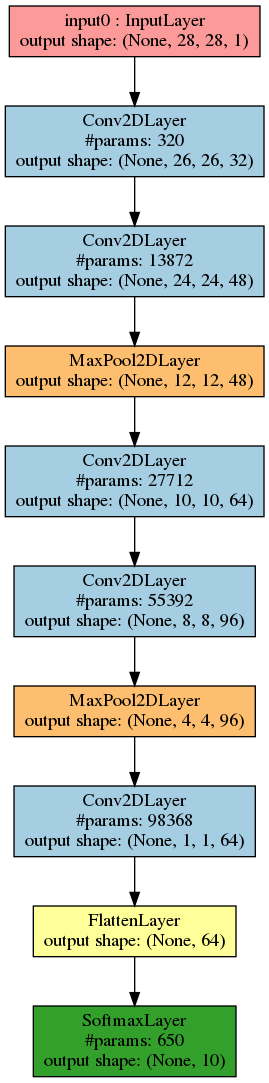

In [18]:
draw_to_notebook(prunned_nn)

As an exercise, pruned network is stored and loaded.

**Note**: deserialization yields a completely new instance of network, including new parameters and variables.
Values of the parameters are preserved.

**Note**: only `cloudpickle` works with `craynn` due to its heavy usage of runtime generated classes and lambda functions.

**Note**: `cloudpickle.dump(a network)` will not serialize values of the variables, since:
- `tf.Variable` is not serializable;
- retrieving value of a `tf.Variable` requires a `session`, however, `craynn` is built to avoid storing `session` anywhere, unless it is absolutely necessary.

In [19]:
with open('darts-pruned.pickled', 'wb') as f:
    f.write(prunned_nn.serialize(session))

In [20]:
with open('darts-pruned.pickled', 'rb') as f:
    restored = Network.deserialize(session, f.read())

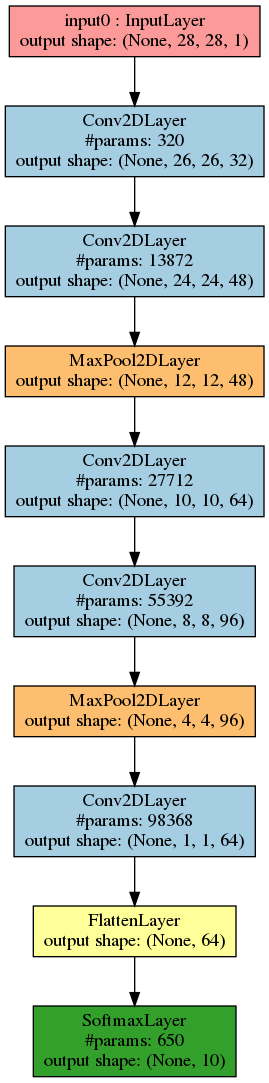

In [21]:
draw_to_notebook(restored)

### Fine tuning

In [22]:
predictions_tune, = prunned_nn(X_train)

In [23]:
regularization = prunned_nn.reg_l2(weights=True)

loss_tune = -tf.reduce_mean(tf.reduce_sum(y_train * tf.log(predictions_tune), axis=1)) + 1.0e-3 * regularization

In [24]:
optimizer_tune = tf_updates.adam()(loss_tune, prunned_nn.variables())

In [25]:
updates_tune = optimizer_tune.updates()

In [26]:
### no need to reset prunned_nn as it is already initialized by `deserialize`
session.run([ optimizer_tune.reset() ])

[None]

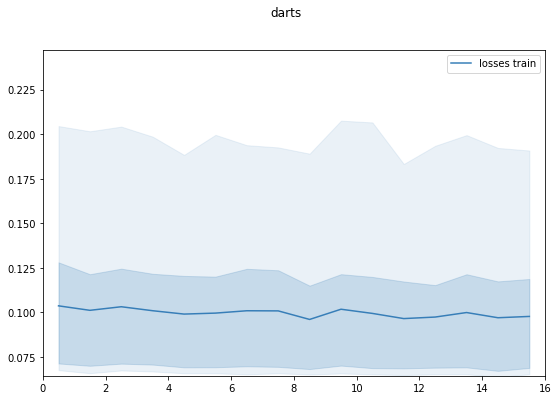

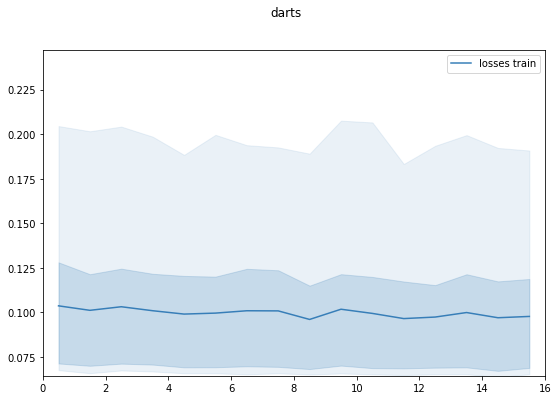

In [27]:
n_epoches = 16
n_batches = data_train.shape[0] // 32

losses_train = np.zeros((n_epoches, n_batches), dtype='float32')

watcher = SimpleWatcher(title='darts', labels=('losses train', ))

for i in range(n_epoches):
    for j in range(n_batches):
        _, losses_train[i, j] = session.run([ updates_train, loss_train])
    
    watcher.draw(losses_train[:(i + 1)])

### Testing

In [28]:
X_test = tf.placeholder(shape=(None, 28, 28, 1), dtype='float32')
predictions_test, = prunned_nn(X_test)

In [29]:
proba = np.concatenate([
    session.run(predictions_test, feed_dict={ X_test : data_test[indx] })
    for indx in streams.seq(data_test, batch_size=32)
], axis=0)

In [30]:
accuracy = np.mean(np.argmax(proba, axis=1) == np.argmax(labels_test, axis=1))

In [31]:
print('Test accuracy: %.3lf' % accuracy)

Test accuracy: 0.986
